# CNN Image Classification on CIFAR-10

### Wilson Tobar

## 0. Setup and Data Preparation


In [1]:
import os
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers, regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

to_categorical = keras.utils.to_categorical
ResNet50 = keras.applications.resnet50.ResNet50
Dense = keras.layers.Dense
Model = keras.models.Model
ResNet101 = keras.applications.resnet.ResNet101
EfficientNetB0 = keras.applications.efficientnet.EfficientNetB0
VGG16 = keras.applications.vgg16.VGG16

/Users/wilsontobar/Downloads/dsci_552_final_project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Transfer Learning for Image Classification.

### (b). Data Exploration and Pre-processing.

#### i. Import Image Data.

In [2]:
data_dir = '../data/RealWaste'

class_folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

train_files = []
test_files = []

train_labels = []
test_labels = []

for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)
    print(f'Processing {class_path}')
    
    files = []
    for img in os.listdir(class_path):
        if img.lower().endswith(('.jpg')):
            files.append(os.path.join(class_path, img))
    print(f'Found {len(files)} file(s)\n')

    files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

    split_ratio = int(len(files) * 0.8)

    train_files.extend(files[:split_ratio])
    test_files.extend(files[split_ratio:])

    class_name = class_folder.split('-')[1]

    train_labels.extend([class_name] * split_ratio)
    test_labels.extend([class_name] * (len(files) - split_ratio))


print("Class distribution in training set:")
for class_name in set(train_labels):
    print(f"{class_name}: {train_labels.count(class_name)} images")

print("\nClass distribution in test set:")
for class_name in set(test_labels):
    print(f"{class_name}: {test_labels.count(class_name)} images")

print(f"\nTotal training images: {len(train_files)}")
print(f"Total test images: {len(test_files)}")

Processing ../data/RealWaste/1-Cardboard
Found 461 file(s)

Processing ../data/RealWaste/2-Food Organics
Found 411 file(s)

Processing ../data/RealWaste/3-Glass
Found 420 file(s)

Processing ../data/RealWaste/4-Metal
Found 790 file(s)

Processing ../data/RealWaste/5-Miscellaneous Trash
Found 495 file(s)

Processing ../data/RealWaste/6-Paper
Found 500 file(s)

Processing ../data/RealWaste/7-Plastic
Found 921 file(s)

Processing ../data/RealWaste/8-Textile Trash
Found 318 file(s)

Processing ../data/RealWaste/9-Vegetation
Found 436 file(s)

Class distribution in training set:
Metal: 632 images
Vegetation: 348 images
Glass: 336 images
Plastic: 736 images
Food Organics: 328 images
Paper: 400 images
Cardboard: 368 images
Miscellaneous Trash: 396 images
Textile Trash: 254 images

Class distribution in test set:
Metal: 158 images
Vegetation: 88 images
Glass: 84 images
Plastic: 185 images
Food Organics: 83 images
Paper: 100 images
Cardboard: 93 images
Miscellaneous Trash: 99 images
Textile Tra

#### One-hot Encoding.

In [3]:
label_encoder = LabelEncoder()

train_labels_int = label_encoder.fit_transform(train_labels)
test_labels_int = label_encoder.transform(test_labels)

num_classes = len(class_folders)
train_labels_onehot = to_categorical(train_labels_int, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels_int, num_classes=num_classes)

print("Class distributions, encoded labels:")
print(f"Train labels (integers): {np.unique(train_labels_int, return_counts=True)}")
print(f"Test labels (integers): {np.unique(test_labels_int, return_counts=True)}")

Class distributions, encoded labels:
Train labels (integers): (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([368, 328, 336, 632, 396, 400, 736, 254, 348]))
Test labels (integers): (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 93,  83,  84, 158,  99, 100, 185,  64,  88]))


#### ii. Image Re-sizing.

In [4]:
def load_and_resize_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img / 255.0
        images.append(img)
    return np.array(images)

print("Loading and Processing images...")
X_train = load_and_resize_images(train_files)
X_test = load_and_resize_images(test_files)

print(f"X train shape: {X_train.shape}")
print(f"X test shape: {X_test.shape}")

Loading and Processing images...
X train shape: (3798, 224, 224, 3)
X test shape: (954, 224, 224, 3)


### (c). Transfer Learning.

##### Setup Parameters and Helper Functions

In [5]:
epochs = 100

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

X_val, X_train_final, y_val, y_train_final = train_test_split(
    X_train, 
    train_labels_onehot, 
    test_size=0.8, 
    stratify=train_labels_onehot
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10
)

def compile_model(model):
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def model_history(model):
    history_obj = model.fit(
        X_train_final,
        y_train_final,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=5,
        callbacks=[early_stopping],
        verbose=0
    )
    return history_obj

def evaluate_model(model, X, y_true_onehot):
    y_pred = model.predict(X, verbose=0)
    y_true = np.argmax(y_true_onehot, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    return {
        'precision': precision_score(y_true, y_pred_classes, average='weighted'),
        'recall': recall_score(y_true, y_pred_classes, average='weighted'),
        'f1': f1_score(y_true, y_pred_classes, average='weighted'),
        'auc': roc_auc_score(y_true_onehot, y_pred, multi_class='ovr'),
        'full_report': classification_report(y_true, y_pred_classes, 
                                           target_names=label_encoder.classes_,
                                           output_dict=True)
    }

def plot_history(history_dict, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    
    best_epoch = np.argmin(history_dict['val_loss'])
    plt.axvline(best_epoch, linestyle='--', color='r', alpha=0.5)
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Train Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.axvline(best_epoch, linestyle='--', color='r', alpha=0.5)
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

##### ResNet50

In [6]:
def build_resnet50_model():
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)

    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(9, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

##### ResNet101

In [7]:
def build_resnet101_model():
    base_model = ResNet101(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(9, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

##### EfficientNetB0

In [8]:
def build_efficientnet_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(9, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

##### VGG16

In [9]:
def build_vgg16_model():
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(9, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

##### Train and Evaluate Models.

Training ResNet50...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,859,337 (91.02 MB)

 Trainable params: 267,529 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 78s 126ms/step - accuracy: 0.2430 - loss: 2.8145 - val_accuracy: 0.3320 - val_loss: 2.1297
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 73s 119ms/step - accuracy: 0.3105 - loss: 2.1286 - val_accuracy: 0.3228 - val_loss: 2.3412
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 72s 119ms/step - accuracy: 0.3190 - loss: 2.0231 - val_accuracy: 0.3702 - val_loss: 2.1300
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 73s 120ms/step - accuracy: 0.3339 - loss: 1.9582 - val_accuracy: 0.3281 - val_loss: 2.1452
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 72s 119ms/step - accuracy: 0.3594 - loss: 1.8931 - val_accuracy: 0.3465 - val_loss: 2.0714
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 72s 118ms/step - accuracy: 0.3565 - loss: 1.9149 - val_accuracy: 0.3966 - val_loss: 1.8991
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 72s 119ms/step - accuracy: 0.3601 - loss: 1.8819 - val_accuracy: 0.3518 - val_loss: 2.0840
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 74s 122ms/step - accuracy: 0.3406 -

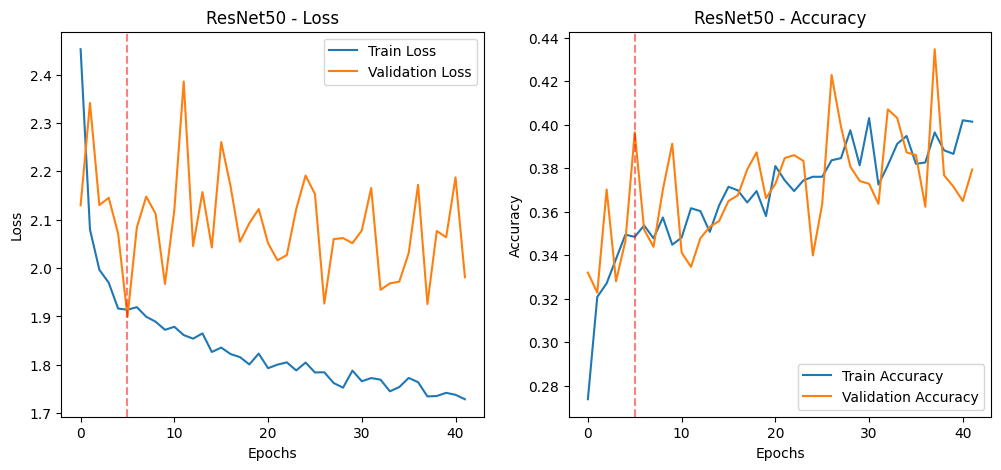

Training ResNet101...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,929,801 (163.76 MB)

 Trainable params: 267,529 (1.02 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 136s 218ms/step - accuracy: 0.2367 - loss: 2.7734 - val_accuracy: 0.3123 - val_loss: 2.2462
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.2898 - loss: 2.1468 - val_accuracy: 0.3188 - val_loss: 2.2360
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 130s 213ms/step - accuracy: 0.3309 - loss: 1.9332 - val_accuracy: 0.3241 - val_loss: 2.3172
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 130s 214ms/step - accuracy: 0.3123 - loss: 1.9807 - val_accuracy: 0.3715 - val_loss: 2.0358
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 131s 216ms/step - accuracy: 0.3156 - loss: 1.9601 - val_accuracy: 0.3478 - val_loss: 2.1789
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 131s 216ms/step - accuracy: 0.3336 - loss: 1.9189 - val_accuracy: 0.3702 - val_loss: 2.0708
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 132s 217ms/step - accuracy: 0.3282 - loss: 1.9100 - val_accuracy: 0.3478 - val_loss: 2.0485
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 133s 219ms/step - accuracy: 

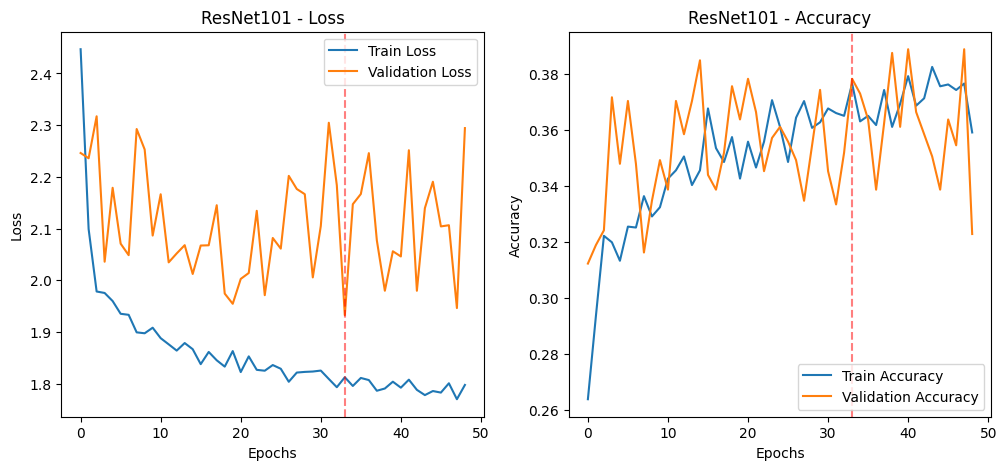

Training EfficientNetB0...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,820 (16.10 MB)

 Trainable params: 167,689 (655.04 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.1001 - loss: 4.4419 - val_accuracy: 0.0962 - val_loss: 2.7623
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.1171 - loss: 2.7694 - val_accuracy: 0.0922 - val_loss: 2.3618
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.1156 - loss: 2.3814 - val_accuracy: 0.1594 - val_loss: 2.2503
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.1031 - loss: 2.2823 - val_accuracy: 0.1924 - val_loss: 2.2227
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.0941 - loss: 2.2503 - val_accuracy: 0.0922 - val_loss: 2.2127
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.1038 - loss: 2.1994 - val_accuracy: 0.0672 - val_loss: 2.2069
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.0981 - loss: 2.1864 - val_accuracy: 0.0870 - val_loss: 2.2020
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.0881 - loss: 2

/Users/wilsontobar/Downloads/dsci_552_final_project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wilsontobar/Downloads/dsci_552_final_project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wilsontobar/Downloads/dsci_552_final_project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

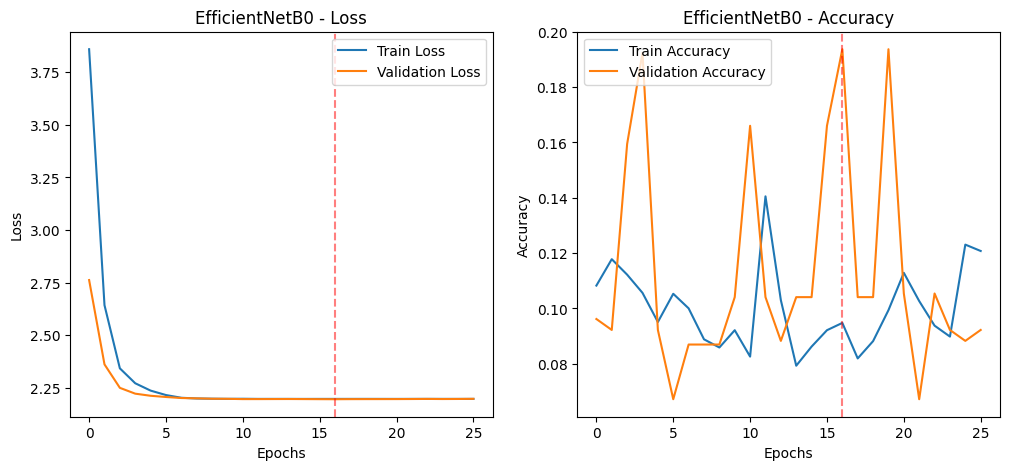

Training VGG16...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,783,561 (56.39 MB)

 Trainable params: 67,849 (265.04 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 181s 297ms/step - accuracy: 0.3903 - loss: 3.2134 - val_accuracy: 0.6680 - val_loss: 1.8114
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 180s 296ms/step - accuracy: 0.5725 - loss: 1.8334 - val_accuracy: 0.6957 - val_loss: 1.3857
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 178s 293ms/step - accuracy: 0.5992 - loss: 1.5325 - val_accuracy: 0.6957 - val_loss: 1.2633
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 178s 293ms/step - accuracy: 0.6157 - loss: 1.4255 - val_accuracy: 0.6917 - val_loss: 1.2302
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 179s 294ms/step - accuracy: 0.6215 - loss: 1.3465 - val_accuracy: 0.6640 - val_loss: 1.2550
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 178s 293ms/step - accuracy: 0.6120 - loss: 1.3574 - val_accuracy: 0.6943 - val_loss: 1.2309
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 178s 293ms/step - accuracy: 0.6172 - loss: 1.3555 - val_accuracy: 0.7009 - val_loss: 1.1999
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 178s 293ms/step - accuracy: 

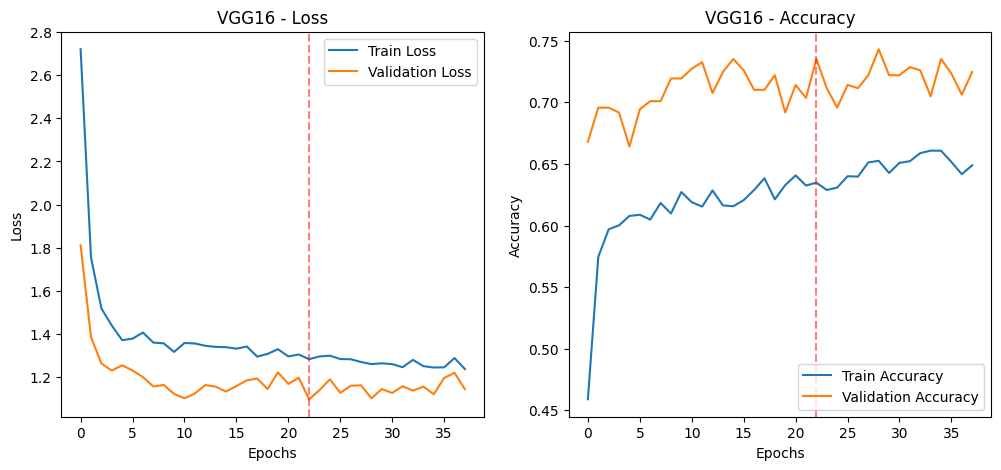

In [10]:
def train_and_evaluate_models(X_test, y_test):
    results = {}

    train_labels_int = np.argmax(y_train_final, axis=1)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels_int),
        y=train_labels_int
    )
    class_weights_dict = dict(enumerate(class_weights))
    
    models = {
        'ResNet50': build_resnet50_model(),
        'ResNet101': build_resnet101_model(),
        'EfficientNetB0': build_efficientnet_model(),
        'VGG16': build_vgg16_model()
    }
    
    for name, model in models.items():
        keras.backend.clear_session()

        print(f"Training {name}...")
        model = compile_model(model)
        model.summary()
        
        history_obj = model.fit(
            X_train_final, y_train_final,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=5,
            callbacks=[early_stopping],
            class_weight=class_weights_dict,
            verbose=1
        )
        
        results[name] = {
            'model': model,
            'history_dict': history_obj.history,
            'history_obj': history_obj,
            'params': model.count_params() / 1e6,
            'metrics': {
                'train': evaluate_model(model, X_train_final, y_train_final),
                'val': evaluate_model(model, X_val, y_val),
                'test': evaluate_model(model, X_test, y_test)
            }
        }
        
        plot_history(history_obj.history, name)
    
    return results

final_results = train_and_evaluate_models(X_test, test_labels_onehot)

#### v. Comparison.

In [11]:
def compare_results(results):
    print(f"{'Model':<15} {'Stage':<8} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10}")
    print("-" * 65)
    
    for name, data in results.items():
        for stage in ['train', 'val', 'test']:
            print(f"{name:<15} {stage:<8} "
                  f"{data['metrics'][stage]['precision']:<10.4f} "
                  f"{data['metrics'][stage]['recall']:<10.4f} "
                  f"{data['metrics'][stage]['f1']:<10.4f} "
                  f"{data['metrics'][stage]['auc']:<10.4f}")
        print("-" * 65)
    
    best_model = max(results.items(), key=lambda x: x[1]['metrics']['test']['f1'])
    print(f"Best Model: {best_model[0]} (Test F1: {best_model[1]['metrics']['test']['f1']:.4f})")

compare_results(final_results)

Model           Stage    Precision  Recall     F1         AUC       
-----------------------------------------------------------------
ResNet50        train    0.4893     0.4525     0.4305     0.8418    
ResNet50        val      0.4394     0.4229     0.3957     0.8100    
ResNet50        test     0.3966     0.3658     0.3323     0.7897    
-----------------------------------------------------------------
ResNet101       train    0.4525     0.4153     0.3961     0.8279    
ResNet101       val      0.3934     0.3781     0.3522     0.8065    
ResNet101       test     0.3643     0.3585     0.3249     0.7838    
-----------------------------------------------------------------
EfficientNetB0  train    0.0277     0.1665     0.0475     0.5000    
EfficientNetB0  val      0.0276     0.1660     0.0473     0.4996    
EfficientNetB0  test     0.0274     0.1656     0.0471     0.5002    
-----------------------------------------------------------------
VGG16           train    0.7832     0.7730    

## Citations and References

* "Lesson-10_Neural Networks and Deep Learning (24)", https://www.dropbox.com/scl/fo/ex32yzmxvfcovsqj5zzxw/AOgyaf-xxTTAk9lXOYbetuk/Lesson-10_Neural%20Networks%20and%20Deep%20Learning%20(24).pdf?rlkey=efeuzuo2w0ypclavfxkwj08xy&e=1&st=qqf69deo&dl=0.

* "How to iterate through images in a folder Python?", https://www.geeksforgeeks.org/how-to-iterate-through-images-in-a-folder-python/.

* "How to convert categorical string data into numeric in Python?", https://www.geeksforgeeks.org/how-to-convert-categorical-string-data-into-numeric-in-python/.

* "LabelEncoder", https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html.

* "Step-by-Step Tutorial: Image Classification with Keras", https://medium.com/%40golnaz.hosseini/step-by-step-tutorial-image-classification-with-keras-7dc423f79a6b.

* "How can I one hot encode a list of strings with Keras?", https://stackoverflow.com/questions/56227671/how-can-i-one-hot-encode-a-list-of-strings-with-keras.

* "Python Keras | keras.utils.to_categorical()", https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/.

* "tf.keras.utils.to_categorical", https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical.

* "Image Resizing using OpenCV in Python", https://www.analyticsvidhya.com/blog/2024/01/image-resizing-using-opencv-in-python/.

* "Python OpenCV cv2.cvtColor() Guide", https://pytutorial.com/python-opencv-cv2cvtcolor-guide/.

* "5 Best Ways to Normalize an Image in OpenCV Python", https://blog.finxter.com/5-best-ways-to-normalize-an-image-in-opencv-python/.

* "What Is Transfer Learning? Exploring the Popular Deep Learning Approach.", https://builtin.com/data-science/transfer-learning.

* "tf.keras.applications.ResNet50", https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50.

* "Transfer learning & fine-tuning", https://keras.io/guides/transfer_learning/.

* "tf.keras.layers.Dense", https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense.

* "Keras layers API", https://keras.io/api/layers/.

* "Better results when adding a dropout layer before a single layer classifier - counter intuitive result", https://datascience.stackexchange.com/questions/122120/better-results-when-adding-a-dropout-layer-before-a-single-layer-classifier-co.

* "TensorFlow Keras: Data Augmentation Techniques", https://www.slingacademy.com/article/tensorflow-keras-data-augmentation-techniques/.

* "The Model class", https://keras.io/api/models/model/.

* "tf.keras.Model", https://www.tensorflow.org/api_docs/python/tf/keras/Model.

* "Batch normalization", https://en.wikipedia.org/wiki/Batch_normalization.

* "BatchNormalization layer", https://keras.io/api/layers/normalization_layers/batch_normalization/.

* "L2 class", https://keras.io/api/layers/regularizers/#l2-class.

* "Dropout layer", https://keras.io/api/layers/regularization_layers/dropout/.

* "Adam", https://keras.io/api/optimizers/adam/.

* "train_test_split", https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html.

* "EarlyStopping", https://keras.io/api/callbacks/early_stopping/.

* "tf.keras.applications.ResNet101", https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet101.

* "tf.keras.applications.EfficientNetB0", https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0.

* "tf.keras.applications.VGG16", https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16.

* "classification_report", https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report.

* "roc_auc_score", https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score.

* "Backend utilities", https://keras.io/2/api/utils/backend_utils/.

* "How to set class weights for imbalanced classes in Keras?", https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras.

* "compute_class_weight", https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html.